In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# modflow utility
import flopy
import flopy.utils.binaryfile as bf


In [2]:
## Set up directory referencing
# Package data
git_dir = os.path.dirname(os.path.dirname(os.getcwd()))
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'CosumnesRiverRecharge':
    git_dir = os.path.dirname(git_dir)
gwfm_dir = '\\'.join(str.split(git_dir,'\\')[0:3])+ '/Box/research_cosumnes/GWFlowModel'
print(git_dir, gwfm_dir)

C:\Users\andrewc\Documents\GitHub\CosumnesRiverRecharge C:\Users\andrewc/Box/research_cosumnes/GWFlowModel


In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'
fig_dir = box_dir+'figures/'
data_dir = box_dir+'data_output/'

In [536]:

def plt_hf_cum_area(hf_tot_df, percentile, label,ax):
    ''' percentiles available are 87, 95 and 99th '''
#     fig,ax = plt.subplots(figsize=(8,4))
    hf_tot_df = hf_tot_df.transpose()*200*200
    hf_tot_df.index = hf_tot_df.index.astype(int)
    hf_max = hf_tot_df.max().max()
    hf_tot_df.plot(colormap='gray',ax=ax, legend=False)
    plt.xlabel('Setback Distance (m)')
    plt.ylabel('Cumulative Area of \nHigh Flow Cells ($m^2$)')
#     plt.title(label)
    plt.title('Vertical Flow ' + str(percentile)+'th percentile Cells Among 100 Realizations')
    plt.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')
    plt.plot([1200,1200],[0,hf_max],color='blue', label = 'Parallel Mean Length')
#     plt.savefig(fig_dir+'high_flow_cells_by_distance_'+label+'_'+str(percentile)+'.png',dpi=600)
    # plt.legend(ncol = 4, loc = (1.05, 0.05))
    


In [578]:
percentile = 95
label='regional'
hf_tot_df = pd.read_csv(data_dir+'surface_highflow_by_distance_'+label+'_'+str(percentile)+'.csv')
label='local'
# each set of 100 rows is a different location
hf_tot_df_local = pd.read_csv(data_dir+'surface_highflow_by_distance_'+label+'_'+str(percentile)+'.csv')
# join local and regional datasets
hf_all = hf_tot_df.append(hf_tot_df_local)
# create clean index for easier referencing
site_order = ['Regional','Blodgett','Mahon','Oneto-Denier']
site_realization = np.vstack((np.repeat(site_order,100),
                              np.tile(np.arange(1,101),int(hf_all.shape[0]/100))))
site_realization_index = pd.MultiIndex.from_arrays(site_realization,names=['Site','Realization'])
hf_all = hf_all.set_index(site_realization_index)
# convert from number of cells to area, m^2
hf_all.loc[:] = hf_all.values*200*200
# plot with setback as x and realizations as label
hf_all.columns = pd.to_numeric(hf_all.columns)

In [582]:
def plt_hf_step_area(hf_tot_df, percentile, label,ax):
    ''' percentiles available are 87, 95 and 99th '''
#     fig,ax = plt.subplots(figsize=(8,4))
    hf_tot_df = hf_tot_df.transpose()
    hf_tot_df.index = hf_tot_df.index.astype(int)

    hf_diff = hf_tot_df.diff(axis=0)
    hf_diff.iloc[0,:] = 0
    hf_max = hf_diff.max().max()
    hf_diff.plot(colormap='gray',legend=False,ax=ax)
    plt.xlabel('Setback Distance (m)')
    plt.ylabel('Area of High \nFlow Cells ($m^2$)')
    plt.title('Vertical Flow '+str(percentile)+'th percentile Cells Among 100 Realizations')
    ax.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')
    ax.plot([1200,1200],[0,hf_max],color='blue', label = 'Parallel Mean Length')
    fig.tight_layout()
    # plt.savefig(fig_dir+'high_flow_cells_diff_by_distance_'+str(percentile)+'.png',dpi=600)
    


Int64Index([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000,
            2200, 2400, 2600, 2800, 3000, 3200],
           dtype='int64')

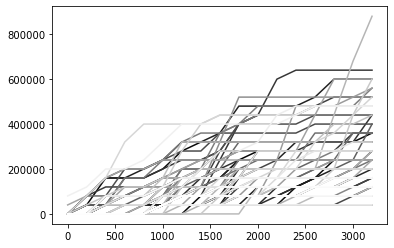

In [580]:
hf_all.loc[n].transpose().plot(legend=False, colormap='gray')
# plt.plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')


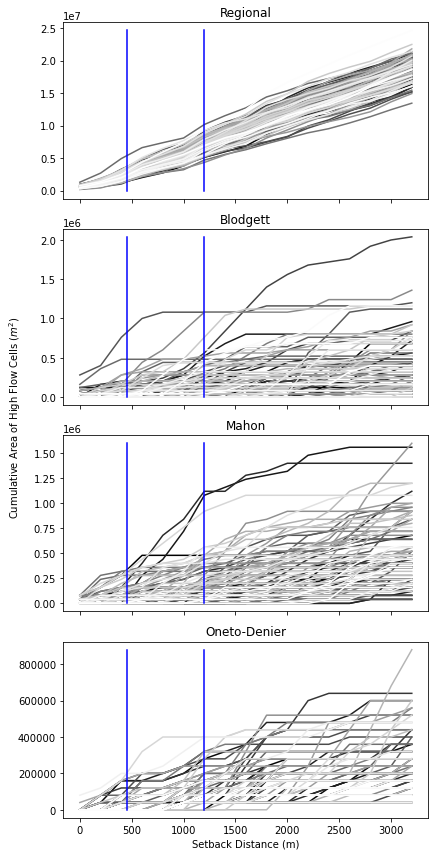

In [588]:
# plot all of these to show initial reaction that on a regional scale all realizations provide high recharge area,
# but local scale these signals are more variable and have more obvious asymptotes
fig,ax=plt.subplots(4,1,figsize=(6,12),sharex=True)
for i,n in enumerate(site_order):
    hf_all.loc[n].transpose().plot(legend=False, colormap='gray',ax=ax[i])
    ax[i].set_title(n)
    hf_max = hf_all.loc[n].max().max()
    ax[i].plot([450,450],[0,hf_max],color='blue',label='Transverse Mean Length')
    ax[i].plot([1200,1200],[0,hf_max],color='blue', label = 'Parallel Mean Length')
#     plt_hf_cum_area(hf_all.loc[n],percentile,n, ax[i])
plt.xlabel('Setback Distance (m)')
fig.text(0,0.4,'Cumulative Area of High Flow Cells ($m^2$)',rotation=90)

fig.tight_layout()
# plt_hf_cum_area(hf_all.loc['Regional'],percentile, 'regional')
# plt_hf_cum_area(hf_all.loc['Blodgett'], percentile, 'local')
# plt_hf_cum_area(hf_all.loc['Mahon'], percentile, 'local')
# plt_hf_cum_area(hf_all.loc['Oneto-Denier'], percentile, 'local')

In [668]:
offset = hf_all.loc['Blodgett'].loc[:,[400,600,800]] - hf_all.loc['Blodgett'].loc[:,[400,600,800]].mean(axis=0)
offset = offset.where(offset == np.min(np.abs(offset)))
offset.loc[:,400]

Realization
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
       ..
96    NaN
97    NaN
98    NaN
99    NaN
100   NaN
Name: 400, Length: 100, dtype: float64

In [691]:
def best_match_realization(offset,param):
    offset = offset.where(offset == np.min(np.abs(offset)))
    closest_means = offset.melt(ignore_index=False).dropna()
    # closest_means.variable.plot(kind='bar', stacked=True)
    most_vals = pd.Series(closest_means.index).value_counts()
    realization = most_vals.sort_values(ascending=False).index[0]
    print('Realization ', realization, ' is closest to the ',param)
    
# realization 90 is closest to the mean for both 600,800 meter setback
dists = np.arange(400,1200,200)
offset = hf_all.loc['Blodgett'].loc[:,dists] - hf_all.loc['Blodgett'].loc[:,dists].mean(axis=0)
best_match_realization(offset,'mean')

offset = hf_all.loc['Blodgett'].loc[:,dists] - hf_all.loc['Blodgett'].loc[:,dists].max(axis=0)
best_match_realization(offset,'max')

offset = hf_all.loc['Blodgett'].loc[:,dists] - hf_all.loc['Blodgett'].loc[:,dists].min(axis=0)
best_match_realization(offset,'min')

Realization  90  is closest to the  mean
Realization  34  is closest to the  max
Realization  1  is closest to the  min


The spread of results generally shows increasing returns for greater setback, however there is a tipping point near the mean lengths values after which maximum gains are found so setback should be slightly greater than the mean lengths in both horizontal directions. An interesting follow up analysis would be the total recharge achieved by high flow cells as a way of understanding what is needed.

In [52]:
# this figure works on the regional scale, but doesn't represent much on the local scale
# plt_hf_step_area(hf_all.loc['Regional'],percentile, 'regional')
# plt_hf_step_area(hf_all.loc['Blodgett'], percentile, 'local')
# plt_hf_step_area(hf_all.loc['Mahon'], percentile, 'local')
# plt_hf_step_area(hf_all.loc['Oneto-Denier'], percentile, 'local')


In [396]:
def plt_hf_stddev(hf_tot_df, percentile, label):
    ''' percentiles available are 87, 95 and 99th '''
    hf_tot_df = hf_tot_df.transpose()*200*200
    hf_tot_df.index = hf_tot_df.index.astype(int)
    # calculate variance in recharge area between realizations
    stddev = hf_tot_df.std(axis=1)
    stddev.plot(colormap='gray',ax=ax, legend=False, label=label)

    plt.xlabel('Setback Distance (m)')
    ax.set_ylabel('Standard Deviation of Cumulative Area \nof High Flow Cells($m^2$)')

    plt.title('Vertical Flow ' + str(percentile)+'th percentile Cells Among 100 Realizations')
    fig.tight_layout()

<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
C:\Users\andrewc\AppData\Local\Temp/ipykernel_200/14346450.py:9: DeprecationWarning: invalid escape sequence \s
  ax.set_ylabel('Coeff. of Variation ($ \\frac{\sigma}{\mu} $)of Cumulative Area \nof High Flow Cells ($m^2$)')


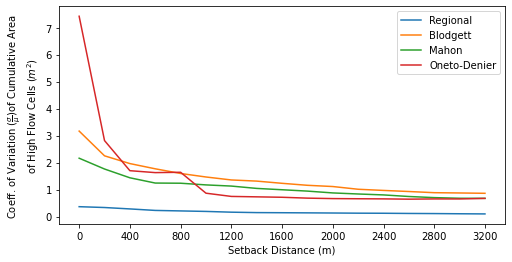

In [107]:
fig,ax = plt.subplots(figsize=(8,4))

# for n in hf_all.index.levels[0]:
#     hf_all.loc[n].std(axis=0).plot(label=n,ax=ax)
# ax.set_ylabel('Standard Deviation of Cumulative Area \nof High Flow Cells Within Setback ($m^2$)')
#hf_all.index.levels[0], reference sites from
for n in site_order:
    (hf_all.loc[n].std(axis=0)/hf_all.loc[n].mean(axis=0)).plot(label=n,ax=ax)
ax.set_ylabel('Coeff. of Variation ($ \\frac{\sigma}{\mu} $)of Cumulative Area \nof High Flow Cells ($m^2$)')

plt.xlabel('Setback Distance (m)')
plt.legend()


The coefficient of variation demonstrates that the local scale setbacks have a higher relative standard deviation between
realizations than on a regional scale. The regional scale show a near constant coefficient of variation and the 3 local sites have similar patterns, reducing variability toward larger setback distances.

## Optimal gradient 

Gaussian filters serve to reduce noise and detail in datasets. They can aid in edge detection in imagery because the noise surrounding contours is reduced. In this case, it reduces detail between setback distances but overall allows a clearer picture of the trend.

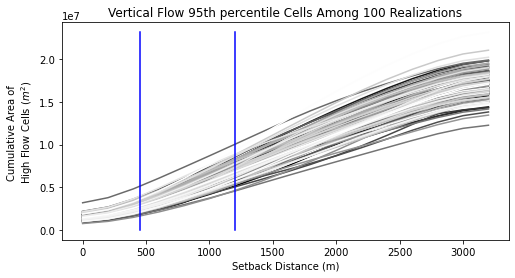

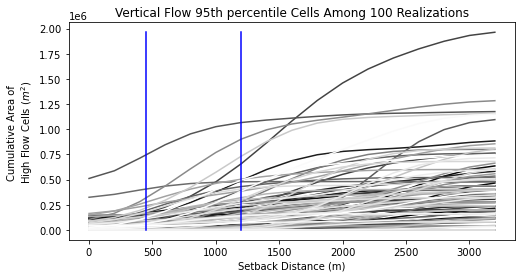

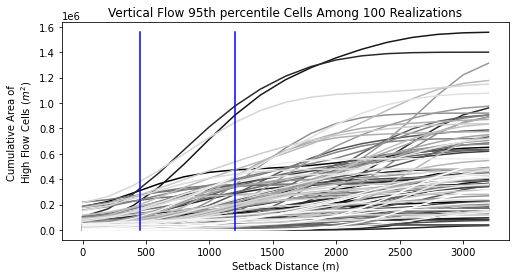

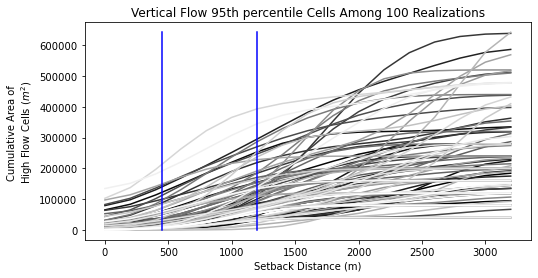

In [137]:
# 1d so the smoothing is specific to each realization
from scipy.ndimage import gaussian_filter1d
# smooth across setback distances so the changes in high flow area are less abrupt, makes it easier to find gradients
smooth = gaussian_filter1d(hf_all,2)

smooth = pd.DataFrame(smooth, index=site_realization_index,columns=np.arange(0,3400,200))
# smooth
# plt_hf_cum_area(hf_all.loc['Regional'], percentile,'Regional')
# fig,ax=plt.subplots(figsize=(6,6))
for n in site_order:
    plt_hf_cum_area(smooth.loc[n], percentile,n)
# ax.set_ylabel('Smoothed Cumulative Area \nof High Flow Cells ($m^2$)')


Grad1 max:  8


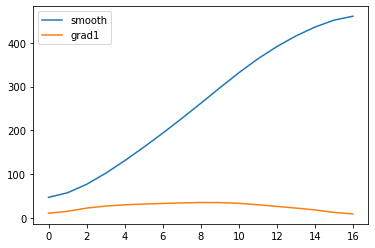

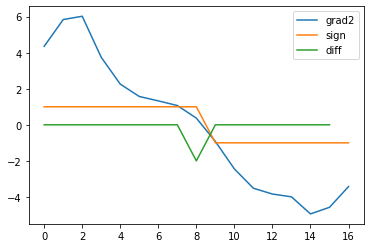

In [426]:
#example of how g
# np.sign gives + or -, np diff gives out[i] = a[i+1] - a[i]. 
# + to - means max of 1st derivative. So diff ==-2 means max, but to account for difference go up one indice
grad1_max = np.where(np.diff(np.sign(grad2_df))==-2)

r = 75
plt.plot(smooth.values[r,:],label='smooth')

plt.plot(grad1_df.values[r,:],label='grad1')
plt.legend()
print('Grad1 max: ',grad1_df.values[r,:].argmax())
plt.show()
plt.plot(grad2_df.values[r,:],label='grad2')

plt.plot(np.sign(grad2_df).values[r,:],label='sign')
plt.plot(np.diff(np.sign(grad2_df))[r,:],label='diff')
plt.legend()

# Plot Smooth, 1st Derivative, Maxima

Text(0.5, 0, 'Setback distance (m)')

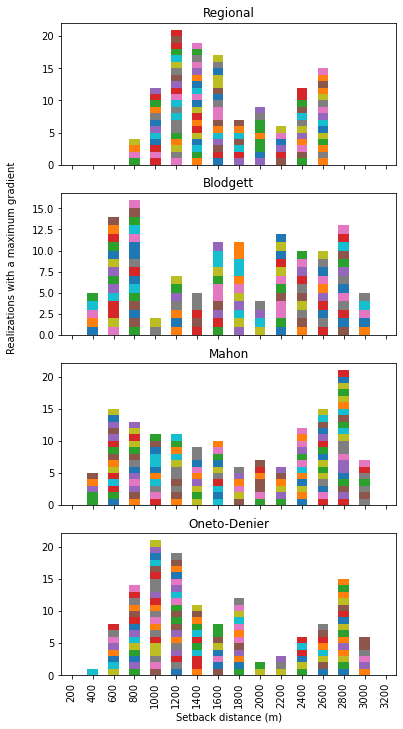

In [586]:
fig,ax=plt.subplots(4,1,figsize=(6,12),sharex=True)
for i,n in enumerate(site_order):
    max_df.loc[n].loc[r].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax[i])
    ax[i].set_title(n)
fig.text(0,0.4,'Realizations with a maximum gradient',rotation=90)
plt.xlabel('Setback distance (m)')

Text(0, 0.5, 'Realizations with a maximum gradient')

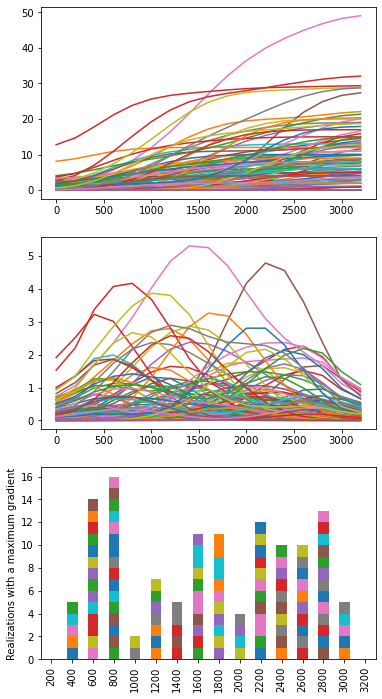

In [456]:
n='Blodgett'
r = np.arange(1,100).astype(str)
# can look at maximum of first derivative, or look where second derivative goes from + to -
grad1_df = pd.DataFrame(np.gradient(smooth)[1], index=site_realization_index, columns = np.arange(0,3400,200))
# plt_hf_cum_area(grad1_df.loc[n].loc[r], percentile, n)

grad2_df = pd.DataFrame(np.gradient(grad1_df)[1], index=site_realization_index, columns = np.arange(0,3400,200))
# # grad2_df
# plt_hf_cum_area(grad2_df.loc[n], percentile, n)
# find switching points
plt.show()
fig,ax=plt.subplots(3,1,figsize=(6,12))
smooth.loc[n].loc[r].transpose().plot(legend=False,ax=ax[0])
plt.ylabel('High K area smoothed with setbacks')

grad1_df.loc[n].loc[r].transpose().plot(legend=False,ax=ax[1])
plt.ylabel('First derivative of High K area')

# plt.legend(ncol=5,loc=(1.2,0.2))
# np.sign gives + or -, np diff gives out[i] = a[i+1] - a[i]. 
# + to - means max of 1st derivative. So diff ==-2 means max, but to account for difference go up one indice
max_df = pd.DataFrame(np.diff(np.sign(grad2_df)), index=site_realization_index,columns = np.arange(200,3400,200))
max_df = 1*(max_df==-2)
max_df.loc[n].loc[r].transpose().plot(kind='bar',legend=False,stacked=True,ax=ax[2])
plt.ylabel('Realizations with a maximum gradient')
# fig.tight_layout()


## Cost Analysis
When looking at the local scale there is much greater variability in the setback distances where the maximum gradient appears. I can plot at which setback distance the gradient occurs and calculate the standard deviation for the three local sites and on the regional scale. I can also plot the variability in the area encompassed by the maximum gradient.  

Calculate XS area gain vs lost after setback to see if volume lost equals volume gained which means no fill dirt purchase is necessary. Then assume excavation cost for only half of it (elevation before > elevation after). This does not account for the need to build levees at a setback distance...  

Average cost to excavate land is 50-200 \\$/cubic yard. Imagine a XS of levee is 300 yd^2, 6000\\$/yd of levee or 2000\\$/ft which gives 10,000,000\\$/mile of levee just to move the earth. This aligns with estimates of levee setback cost of 2.5-5M\\$ in washington state to up to 20M\\$ in Sacramento. According to acrevalue.com the average cost of an acre of farmland in Sac county is 20K\\$/acre. Per mile of 3200 m levee setback in both directions requires 2,500 acres of land which would put an average land cost of \\$51,000,000, at 400m back we would see 6,400,000

I need to calculate what is considered diminishing returns. At what rate of area gained by distance setback is it not worth it? I could do some calculations on the cost benefit of recharge and the cost of the land and setback
Each AF recharged equals about 4 ft of head increase in that local area, should you consider the value of recharge as reduction in pumping cost or actual cost of water saved for future; I lean toward water saved cost because we need to replenish aquifers to prevent overdraft, but I could see farmers/ag-res only viewing it as reduction in pumping energy because they assume groundwater will naturally maintain itself.  
The cost analysis should be done on the 1-2 year flood scale (2000 cfs) and the 20 year flood scale (10,000 cfs) to show water recharged typically and benefit from less frequent big events. Because if 600k $ is done every year that is substantial, but more likely that would only occur during 20 year events with big recharge volumes.  
Optimization looks along the setback distance vs high recharge area plot following these rules: 
1. Setback distance must be >= 0 and <= 3200 m
2. Maximize the function benefit = dollars of water recharged - cost of setback and land  

If I want to publish in an engineering journal then I need to include cost, if I'm seeking for more general scientific advancement then I should not directly include cost. The issue I'm having without cost is finding a way to pick the best setback distance with derivatives or maximum returns.  

gravel K = 4E-3 m/s
sand K = 1.5E-3 m/s  
**GW Pumping energy cost**  
C = 0.746 Q h c / (3960 μp μm)  
C = cost per hour (USD/hour, EUR/hour, ...)  
Q = volume flow (US gpm), h = differential head (ft)  
c = cost rate per kWh (USD/kWh, EUR/kWh, ....)  
μp = pump efficiency (0 - 1), μm= motor efficiency (0 - 1)  

In [593]:
# Q = 500 # gpm, average between domestic 100 and ag 1000
h = 80 # ft, typical DTW in basin
c = 0.24 # USD/kWh, pge lists 24cents as low, 34 as tier 2
ep = 0.9
em = 0.9
C_gpm_1 = 0.746 *h* c*24 / (3960 *ep *em) # USD/day/gpm
C_AF_1 = C_gpm_1/(1/7.48)/(1/43560)/(60*24) #USD/day/AFd
h= 76
C_gpm_2 = 0.746 *h* c*24 / (3960 *ep *em) # USD/day/gpm
C_AF_2 = C_gpm_2/(1/7.48)/(1/43560)/(60*24) #USD/day/AFd
print('Cost per acre foot to pump GW for SASb: $%.2f '%C_AF_1) # USD/day/AFd or USD/AF
print('Cost per acre foot change per 1 ft recharge for SASb: $%.2f '%(C_AF_1-C_AF_2)) # USD/day/AFd or USD/AF
C_AF = C_AF_1

Cost per acre foot to pump GW for SASb: $24.25 
Cost per acre foot change per 1 ft recharge for SASb: $1.21 


In [591]:
from scipy.stats import gmean
# K m/s
K_grv = 4E-3
K_snd = 1.5E-3
# take geometric mean and convert to m/day
K_coarse = gmean([K_grv,K_snd])*86400
z_aniso = 100 # log between 100, 1000
K_coarse /= z_aniso
K_coarse



2.116359137764666

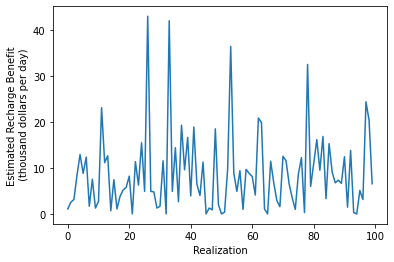

Text(0.5, 0, 'Realization')

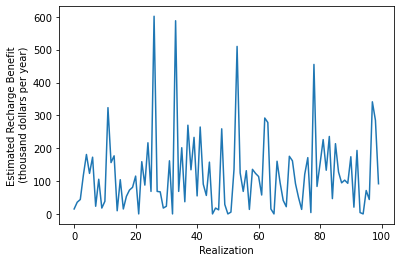

In [594]:
# hf_tot_df_local.iloc[0:100].mean(axis=0).plot()
# mean number of cells for all setbacks for each realization
mean_area = hf_tot_df_local.iloc[0:100].mean(axis=1)*200*200
# m3/day
m3_AF = (1/0.3048**3)*(1/43560)
# looks like 200 AF per day is doable for most realizations, also would expect the flooding to happen for may 1-2 weeks per year
(K_coarse*mean_area*m3_AF*C_AF/1000).plot()
plt.ylabel('Estimated Recharge Benefit\n (thousand dollars per day)')
plt.xlabel('Realization')
plt.show()
# cost of surface water in sacramento valley $50-100/AF
# cost of pumping?

(K_coarse*mean_area*m3_AF*C_AF*14/1000).plot()
plt.ylabel('Estimated Recharge Benefit\n (thousand dollars per year)')
plt.xlabel('Realization')

Start with the best case scenario that every year every high recharge cell in the setback is activated with 0.5 meters of water (or calculated flood depth) which is typical of the flatter cross-sections. Then assume a cost of $50/AF water recharged and annualize the cost. Annualize cost of levee construction then perform cost benefit optimization.

In [241]:
local_setback = gpd.read_file(gwfm_dir+'/levee_setback/local_levee_setback_rectangles/local_levee_setback_rectangles.shp')
local_setback = local_setback.dropna()

C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\andrewc\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array

In [275]:
local_setback.geometry.iloc[0].area
for n in np.arange(0,len(local_setback)):
    xy = list(local_setback.geometry.iloc[n].exterior.coords)
    xy_dists = np.sum(np.sqrt(np.diff(xy,axis=0)**2),axis=1)
    local_setback.loc[n,'width_m'] = np.min(xy_dists)


In [595]:
const_cost_m3 = 200 # 200$/m3 or yd3
land_cost_m2 = 20000/43560/0.3048 # convert from cost per acre to cost per sq. ft then to sq m



In [596]:
const_int = 0.08 # higher interest rate for productive investments and lets assume levees are built for 100 years
num_pers = 100 # number of periods, assume interest is compounding annually
x_dist_m = 400 # setback distance total, increments of 400 from 400 to 6400 m
const_cost = 2000/0.3048 # approx cost to move earth per meter of levee times total length (62 km) or local length (~2250 m)
# land_cost = 2000/0.3048 # approx cost to move earth per meter of levee times total length (62 km) or local length (~2250 m)

annual_cost = (const_cost*62000 + land_cost_m2*x_dist_m*62000)*(const_int/(1-(1+const_int)**(-num_pers)))

const_int, 0.08/12
print('Annualized cost for all work is %.2f M$' %(annual_cost/1E6))
# annual_cost = const_cost*2250

Annualized cost for all work is 35.55 M$


In [597]:
const_int = 0.08 # higher interest rate for productive investments and lets assume levees are built for 100 years
num_pers = 100 # number of periods, assume interest is compounding annually
x_dist_m = 400 # setback distance total, increments of 400 from 400 to 6400 m
const_cost = 2000/0.3048 # approx cost to move earth per meter of levee times total length (62 km) or local length (~2250 m)
# land_cost = 2000/0.3048 # approx cost to move earth per meter of levee times total length (62 km) or local length (~2250 m)

annual_cost = (const_cost*2250 + land_cost_m2*x_dist_m*2250)*(const_int/(1-(1+const_int)**(-num_pers)))

const_int, 0.08/12
print('Annualized cost for all work is %.2f M$' %(annual_cost/1E6))
# annual_cost = const_cost*2250

Annualized cost for all work is 1.29 M$


because the cost so much greatly outweighs any potential benefit, rather than maximing profit we will focus on minimizing cost

In [598]:
def annual_cost(x, df):
    x = int(x)
    x_dist_m = np.arange(0,6800,400)[x]
    annual_cost = (const_cost*2250 + land_cost_m2*x_dist_m*2250)*(const_int/(1-(1+const_int)**(-num_pers)))
    annual_benefit = (df.iloc[x]*200*200*0.5)*50*m3_AF
    net_cost = annual_cost - annual_benefit
    return(net_cost)

In [599]:
from scipy.optimize import fsolve, least_squares, minimize, minimize_scalar
# fsolve(mannings, [2], args = (Q_cms, xs_elevs), xtol=1E-5)
# least_squares(mannings, [2], args = (Q_cms, xs_elevs), bounds = (0, 10), ftol=1E-5)
# minimize(mannings, [1.], args = (Q_cms, xs_elevs), bounds=[(0,10)], tol=1E-5)

res = minimize_scalar(annual_cost,  args = (hf_tot_df.iloc[0]), bounds=(0,17), method='bounded')
res


     fun: 1172721.6842433221
 message: 'Solution found.'
    nfev: 30
  status: 0
 success: True
       x: 0.5855155639709074

<AxesSubplot:>

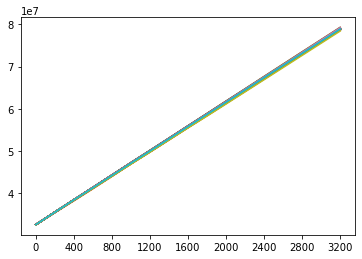

In [600]:

x_dist_m = np.arange(0,6800,400)
annual_cost = (const_cost*62000 + land_cost_m2*x_dist_m*62000)*(const_int/(1-(1+const_int)**(-num_pers)))
annual_benefit = (hf_tot_df*200*200*2)*50*m3_AF 
net_cost = annual_cost - annual_benefit
net_cost.transpose().plot(legend=False)
# on a regional scale this will never be cost effective, even at 1000$/AF the zero setback is mostly the minimum

Text(0, 0.5, 'Net cost ($)')

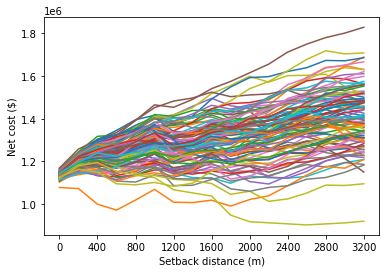

In [601]:

x_dist_m = np.arange(0,6800,400)
annual_cost = (const_cost*2250 + land_cost_m2*x_dist_m*2250)*(const_int/(1-(1+const_int)**(-num_pers)))
annual_benefit = (hf_tot_df*200*200*2)*50*m3_AF 
net_cost = annual_cost - annual_benefit
net_cost.transpose().plot(legend=False)
plt.xlabel('Setback distance (m)')
plt.ylabel('Net cost ($)')
# as the recharge depth increases we see more variability in the plots and the minimum
# values are no longer at a zero setback distances
# I could plot minimum values at different recharge rates to avoid the flood mapping, but I think
# flood mapping is the best way

In [602]:
annual_benefit/annual_cost

,0,200,400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600,2800,3000,3200
0,0.030188,0.047758,0.069557,0.107582,0.136485,0.178677,0.247724,0.287335,0.324334,0.365125,0.381982,0.408221,0.429556,0.436596,0.437066,0.459432,0.485692
1,0.035677,0.050271,0.120565,0.182889,0.216770,0.248268,0.318503,0.345804,0.363887,0.386161,0.414887,0.436892,0.463503,0.486635,0.519916,0.548317,0.565714
2,0.043910,0.087974,0.143750,0.189344,0.240856,0.270837,0.336197,0.364180,0.390782,0.428233,0.450653,0.471024,0.487005,0.500396,0.517514,0.531002,0.543486
3,0.016466,0.042730,0.083468,0.135553,0.170606,0.210651,0.272497,0.309052,0.325916,0.378648,0.397719,0.423239,0.438696,0.457862,0.471887,0.485982,0.502363
4,0.024699,0.047758,0.076512,0.131250,0.158563,0.186201,0.226491,0.248912,0.270542,0.323053,0.361953,0.402760,0.408666,0.429090,0.443069,0.465204,0.491249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.030188,0.057812,0.120565,0.172131,0.200713,0.225698,0.283113,0.322416,0.341737,0.374140,0.404872,0.436892,0.453058,0.466619,0.479091,0.485982,0.492360
96,0.019211,0.042730,0.083468,0.135553,0.172613,0.197486,0.272497,0.309052,0.324334,0.351602,0.369106,0.390472,0.399527,0.420333,0.431062,0.434036,0.444569
97,0.019211,0.040217,0.081149,0.150614,0.174620,0.197486,0.244185,0.300699,0.338573,0.378648,0.396288,0.420509,0.440002,0.464117,0.486295,0.504452,0.516812
98,0.052143,0.085461,0.146069,0.234528,0.297055,0.347951,0.417592,0.457731,0.493620,0.560459,0.595148,0.615745,0.634542,0.651766,0.664003,0.675296,0.684636


In [603]:
50*m3_AF # the value of water ends of 0.05 dollars per m^3 which is similar to Thomas' values with Mehrdad
 # area of recharge times depth (assumed 0.5 m now) * values/volume and assume yearly
yearly_value = (hf_tot_df*200*200*0.5)*50*m3_AF
# iterate through each realization
yearly_value.iloc[0,:]

0         8917.845132
200      15403.550682
400      24321.395814
600      40535.659689
800      55128.497178
1000     77017.753410
1200    113499.847131
1400    139442.669332
1600    166196.204727
1800    197003.306091
2000    216460.422742
2200    242403.244943
2400    266724.640757
2600    282938.904633
2800    295099.602540
3000    322663.851128
3200    354281.665686
Name: 0, dtype: float64

## High K Cell Group Area statistics 

In [484]:
def stats_cell2area(df):
    ''' convert cell count stats to areas'''
    df.Mean *= 200**2
    df.Max *= 200**2
    df.Min *= 200**2
    df.Median *= 200**2
    df.Setback *= 200
#     df = df.set_index('Realization')
    return(df)

cell_stats_all=pd.read_csv(data_dir+'surface_highflow_cells_statistics_regional'+str(percentile)+'.csv')
cell_stats_all = stats_cell2area(cell_stats_all)
cell_stats_all['Location'] = 0
cell_stats_all['Site'] = 'Regional'
# 1:BLodgett, 2:Mahon, 3:Oneto-Denier
site_dict = {1:'Blodgett',2:'Mahon',3:'Oneto-Denier'}
cell_stats_all_local = pd.read_csv(data_dir+'surface_highflow_cells_statistics_local'+str(percentile)+'.csv')
cell_stats_all_local = stats_cell2area(cell_stats_all_local)
cell_stats_all_local['Site'] = list(site_dict[k] for k in cell_stats_all_local.Location.values)

cell_stats_all = cell_stats_all.append(cell_stats_all_local)
cell_stats_all = cell_stats_all.set_index(['Site','Realization'])
cell_stats_all['Mean_Num_Grps'] = cell_stats_all.Mean/cell_stats_all.Num_Grps


<AxesSubplot:xlabel='Setback'>

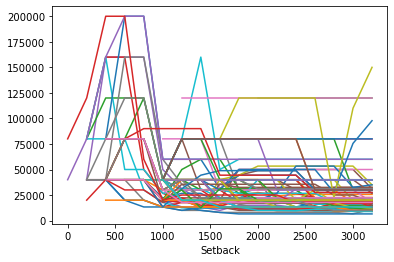

In [520]:
n='Oneto-Denier'
cell_stats_all.loc[n].pivot_table(columns='Realization',values='Mean_Num_Grps',index='Setback').plot(legend=False)

A high number of groups with small mean areas suggests there is no one best place generally to place setbacks, while if the number of groups is small with large mean areas then it is worthwhile creating focused setback.
Compare number of groups to mean area: doesn't seem to be a clear pattern in the mean area divided by the number of groups on a local scale, on a regional scale area divided by number of groups decreases with setback probably because as seback increases there are more small groups but not as many large groups. It could be on a local scale each realiztaion has significantly different outcrops so how it happens isn't regular unless you have geophysical data. This approach can't approximate best locations, only best distances based on cumulated high K area.

Text(0, 0.5, 'Number of High Flow Area Groups')

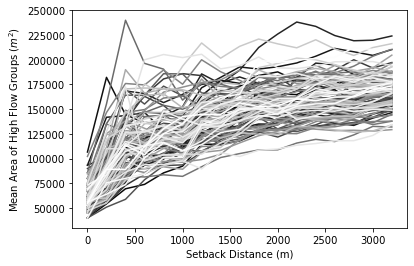

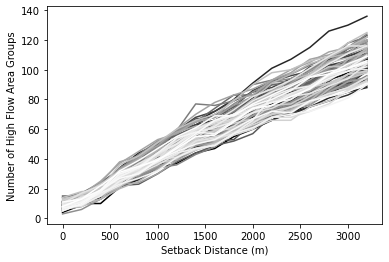

In [526]:
# pd.DataFrame(cell_stats_all_local.loc[:,'Max'])
param='Max'
def plt_cell_stats(df, param):
    df = df.loc[:,[param,'Setback']].pivot_table(values=param, columns='Realization', index='Setback')
    df.plot(colormap='gray', legend=False)
    plt.ylabel(param+' Area of High Flow Groups ($m^2$)')
    plt.xlabel('Setback Distance (m)')
    
    
# plt_cell_stats(cell_stats_all,'Max')
n='Regional'
plt_cell_stats(cell_stats_all.loc[n],'Mean')

plt_cell_stats(cell_stats_all.loc[n],'Num_Grps')
plt.ylabel('Number of High Flow Area Groups')